# Notebook Initialisation

In [1]:
from os import getcwd, pardir
from os.path import join, abspath

! jupyter nbextension enable --py --sys-prefix widgetsnbextension
# init_notebook_mode(connected=True)

## Get Root Directory
rootDirectory = abspath(join(abspath(join(getcwd(), pardir)), pardir))

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')

## Create a button that hides cells
from IPython.display import HTML

HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
            $('div.input').show();
        } else {
            $('div.input').hide();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

%load_ext autoreload
%autoreload 2

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Test Load

## CSV

In [2]:
from test_utils import *

testsDir = join(rootDirectory, 'smartcitizen-iscape-data')

def loadButton(b):
    frequency = frequency_text.value + frequency_drop.value
    readings_selected = loadTest(frequency)
    if readings_selected.keys() == []:
        print 'Select a test to load'
    else:
        for key in readings_selected.keys():
            try:
                readings[key] = dict()
                readings[key] = readings_selected[key]
            except NameError:
                global readings
                readings = dict()
                readings[key] = readings_selected[key]

def clearButton(b):
    
    global readings
    clearTests()
    readings = {}

display(widgets.HTML('<hr><h4>Import Local Tests</h4>'))

tests = getTests(testsDir)
interact(selectTests,
         x = widgets.SelectMultiple(options=tests, 
                           selected_labels = selectedTests, 
                           layout=widgets.Layout(width='700px')))

loadB = widgets.Button(description='Load Local Tests')
loadB.on_click(loadButton)

frequency_text = widgets.Text(description = 'Frequency',
                              value = '1',
                              layout = widgets.Layout(width='300px'))
frequency_drop = widgets.Dropdown(options = ['H', 'Min', 'S', 'ms'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='100px'))

frequency_box = widgets.HBox([frequency_text, frequency_drop])

resetB = widgets.Button(description='Clear Tests')
resetB.on_click(clearButton)

buttonBox = widgets.HBox([loadB, resetB])
totalBox = widgets.VBox([frequency_box, buttonBox])
display(totalBox)

------------------------------------------------------


## Test Load

Loading test **2018-12_INT_NOISE_SAMPLING**

<p><strong>Comment:</strong> 
Noise sampling Test</p>

### KIT

#### KIT

Kit **KIT** located **Europe/Madrid**

Kit **KIT** has been loaded

------------------------------------------------------


# Plots

-------------------------------------
 Medias:

 KIT_Processed	Noise dBA	54.53
 KIT_Processed	Noise_aggregate_2S_every_60S	54.45
 KIT_Processed	Noise_aggregate_3S_every_60S	54.46
-------------------------------------
-------------------------------------
 Std Deviation:

 KIT_Processed	Noise dBA	6.44
 KIT_Processed	Noise_aggregate_2S_every_60S	4.63
 KIT_Processed	Noise_aggregate_3S_every_60S	4.43
-------------------------------------


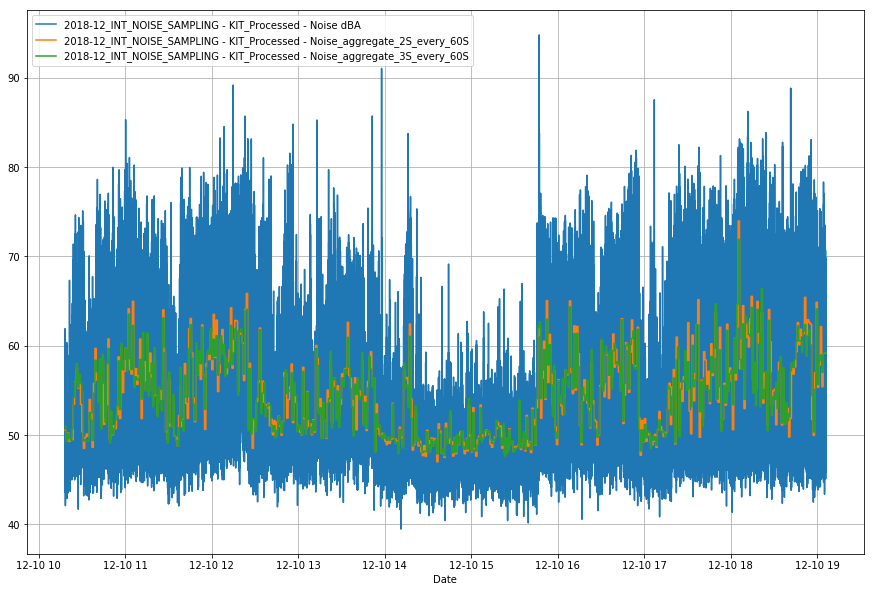

In [196]:
from IPython.display import display, Markdown, FileLink, FileLinks, clear_output, HTML
from IPython.core.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# --
# Plotly
import plotly as ply
import plotly.graph_objs as go
from plotly.widgets import GraphWidget
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls

import matplotlib.pyplot as plot

init_notebook_mode(connected=True)

# Plot Y limits
setLimits = False
maxY = 15000
minY = 0

toshow = []
axisshow = []
# meanTable = []

def show_devices(Source):
    try:
        _device.options = [s for s in list(readings[Source]['devices'].keys())]
        _device.source = Source
        #_min_date.value = readings[Source].index.min()._short_repr
        #_max_date.value = readings[Source].index.max()._short_repr
    except:
        pass
    
def show_sensors(Source):
    try:
        _sensor_drop.options = [s for s in list(readings[_test.value]['devices'][Source]['data'].columns)]
        _sensor_drop.source = Source
        _min_date.value = readings[_test.value]['devices'][Source]['data'].index.min()._short_repr
        _max_date.value = readings[_test.value]['devices'][Source]['data'].index.max()._short_repr
    except:
        pass

def clear_all(b):
    clear_output()
    del toshow[:]
    del axisshow[:]

def add_sensor(b):
    clear_output()
    d = [_device.source, _sensor_drop.source, _sensor_drop.value]
    
    if d not in toshow: 
        toshow.append(d)
        axisshow.append(_axis_drop.value)
        
    plot_data = readings[toshow[0][0]]['devices'][toshow[0][1]]['data'].loc[:,(toshow[0][2],)]
    list_data_primary = []
    list_data_secondary = []
    list_data_terciary = []
    
    if b.slice_time:
        plot_data = plot_data[plot_data.index > _min_date.value]
        plot_data = plot_data[plot_data.index < _max_date.value]
    
    if len(toshow) > 1:
        for i in range(1, len(toshow)):
            plot_data = pd.merge(plot_data, readings[toshow[i][0]]['devices'][toshow[i][1]]['data'].loc[:,(toshow[i][2],)], left_index=True, right_index=True)
    # plot_data = plot_data.groupby(pd.Grouper(freq='10Min')).aggregate(np.mean)    

    print ('-------------------------------------')
    print (' Medias:\n')
    meanTable = []
    for d in toshow:
        myMean = ' ' + d[1]  + "\t" + d[2] + "\t"
        meanTable.append(myMean)   
    res = plot_data.mean()
    for i in range(len(meanTable)): print (meanTable[i] + '%.2f' % (res[i]))
    print ('-------------------------------------')
    
    print ('-------------------------------------')
    print (' Std Deviation:\n')
    stdTable = []
    for d in toshow:
        myStd = ' ' + d[1]  + "\t" + d[2] + "\t"
        stdTable.append(myStd)   
    std = plot_data.std()
    for i in range(len(stdTable)): print stdTable[i] + '%.2f' % (std[i])
    print ('-------------------------------------')

    # Change columns naming
    changed = []
    for i in range(len(plot_data.columns)):
        changed.append(toshow[i][0] + ' - '+ toshow[i][1] + ' - '+ plot_data.columns[i])
    plot_data.columns = changed
    
    subplot_rows = 0
    if len(toshow) > 0:
        for i in range(len(toshow)):
            if axisshow[i]=='1': 
                list_data_primary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,1)
            if axisshow[i]=='2': 
                list_data_secondary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,2)
            if axisshow[i]=='3': 
                list_data_terciary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,3)
          
    
    if _matplotly.value == 'Plotly':
        fig1 = tls.make_subplots(rows=subplot_rows, cols=1, shared_xaxes=_synchroniseXaxis.value)
    
        #if len(list_data_primary)>0:
            #fig1 = plot_data.iplot(kind='scatter', y = list_data_primary, asFigure=True, layout = layout)
        #ply.offline.iplot(fig1)
        
        for i in range(len(list_data_primary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_primary[i]], 'type': 'scatter', 'name': list_data_primary[i]}, 1, 1)
    
        for i in range(len(list_data_secondary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_secondary[i]], 'type': 'scatter', 'name': list_data_secondary[i]}, 2, 1)
        
        for i in range(len(list_data_terciary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_terciary[i]], 'type': 'scatter', 'name': list_data_terciary[i]}, 3, 1)
    
        if setLimits: 
            fig1['layout'].update(height = 800,
                                legend=dict(x=-.1, y=1.2) ,
                               xaxis=dict(title='Time'))
                              
        else:
            fig1['layout'].update(height = 800,
                                  legend=dict(x=-.1, y=1.2) ,
                               xaxis=dict(title='Time'))
                               
        ply.offline.plot(fig1)
        
    elif _matplotly.value == 'Matplotlib':
        
        fig, axes = plot.subplots(subplot_rows, 1, figsize=(15,10))
        # Four axes, returned as a 2-d array
        
        if subplot_rows == 1:
            for i in range(len(list_data_primary)):
                axes.plot(plot_data.index, plot_data[list_data_primary[i]], label =  list_data_primary[i])
                axes.legend(loc='best')

        else:
            for i in range(len(list_data_primary)):
                axes[0].plot(plot_data.index, plot_data[list_data_primary[i]], label =  list_data_primary[i])
                axes[0].legend(loc='best')
                axes[0].grid(visible = True)

            for i in range(len(list_data_secondary)):
                axes[1].plot(plot_data.index, plot_data[list_data_secondary[i]], label =  list_data_secondary[i])
                axes[1].legend(loc='best')
                axes[1].grid(visible = True)

            for i in range(len(list_data_terciary)):
                axes[2].plot(plot_data.index, plot_data[list_data_terciary[i]], label =  list_data_terciary[i])
                axes[2].legend(loc='best')
                axes[2].grid(visible = True)

        plot.xlabel('Date') 
        plot.grid(visible = True)
        plot.show()
        
    
def reset_time(b):
    _min_date.value = readings[b.src.value].index.min()._short_repr
    _max_date.value = readings[b.src.value].index.max()._short_repr

layout=widgets.Layout(width='330px')

# Test dropdown
_test = widgets.Dropdown(options=[k for k in readings.keys()], 
                        layout=layout,
                        description = 'Test')

_test_drop = widgets.interactive(show_devices, 
                                Source=_test, 
                                layout=layout)

# Device dropdown
_device = widgets.Dropdown(layout=layout,
                        description = 'Device')

_device_drop = widgets.interactive(show_sensors, 
                                Source=_device, 
                                layout=layout)

# Sensor dropdown
_sensor_drop = widgets.Dropdown(layout=layout,
                               description = 'Channel')

# Buttons
_b_add = widgets.Button(description='Add to Plot', layout=widgets.Layout(width='120px'))
_b_add.on_click(add_sensor)
_b_add.slice_time = False
_b_reset_all = widgets.Button(description='Clear all', layout=widgets.Layout(width='120px'))
_b_reset_all.on_click(clear_all)

# Axis dropdown
_axis_drop = widgets.Dropdown(
    options=['1', '2', '3'],
    value='1',
    description='Subplot:',
    disabled=False,
)

# Synchronise Checkbox
_synchroniseXaxis = widgets.Checkbox(value=False, 
                                     description='Synchronise X axis', 
                                     disabled=False, 
                                     layout=widgets.Layout(width='300px'))

_matplotly = widgets.RadioButtons(
    options=['Matplotlib', 'Plotly'], value='Matplotlib',
    description='Plot Type',
    disabled=False
)

# Date fields
_min_date = widgets.Text(description='Start date:', 
                         layout=widgets.Layout(width='330px'))
_max_date = widgets.Text(description='End date:', 
                         layout=widgets.Layout(width='330px'))

# Date buttons
_b_apply_time = _b_reset = widgets.Button(description='Apply dates', layout=widgets.Layout(width='100px'))
_b_apply_time.on_click(add_sensor)
_b_apply_time.slice_time = True
_b_reset_time = _b_reset = widgets.Button(description='Reset dates', layout=widgets.Layout(width='100px'))
_b_reset_time.on_click(reset_time)
#_b_reset_time.src = _kit


_device_box = widgets.HBox([_test_drop, _device_drop])
_sensor_box = widgets.HBox([_sensor_drop, _axis_drop, _synchroniseXaxis])
_plot_type_box = widgets.VBox([_matplotly])

_plot_box = widgets.HBox([_b_add , _b_reset_all])
_time_box = widgets.HBox([_min_date,_max_date, _b_reset_time, _b_apply_time])
_root_box = widgets.VBox([_matplotly, _time_box, _device_box, _sensor_box, _plot_box])
display(_root_box)

# Analysis

In [3]:
def evaluate(y_hat, y, p = True, v = False):
    y_hat = y_hat.dropna()
    errors = abs(y_hat - y)
    if p:
        fig = plot.figure(figsize=(10,8))
        plot.plot(y, label = 'Reference')
        plot.plot(y_hat, label = 'Prediction')
        plot.plot(errors, label = 'Errors')
    rerror = np.maximum(np.minimum(np.divide(errors, y),1),-1)
    if p:
        plot.plot(rerror, label = 'Relative Error')
        plot.legend(loc='best')
    mape = 100 * np.mean(rerror)
    accuracy = 100 - mape
    if v:
        print('Model Performance')
        print('\tAverage Error: {:0.4f}.'.format(np.mean(errors)))
        print('\tAccuracy = {:0.2f}%.'.format(accuracy))
    
    return mape, accuracy

In [4]:
import matplotlib.pyplot as plt
import collections
test = readings['2018-12_INT_NOISE_SAMPLING']['devices']['KIT']['data'].copy()
%matplotlib inline
# Take samples with and without averaging
noise_series = test['Noise dBA']
list_freqs_resample = ['400ms','1S', '2S', '5S', '10S', '20S', '30S', '60S', '120S']
list_freqs_average = ['200ms', '400ms','600ms', '800ms', '1S', '1.2S', '1.4S', '1.6S', '1.8S', '2S', '2.2S', '2.4S', '2.6S', '2.8S', '3S']
accuracy_dict = {}

for freq in list_freqs_resample:
    # # without average
    # name = 'Noise_resample_' + str(freq)
    # test[name] = noise_series.resample(freq, how='first')
    # test[name] = test['Noise_resample_' + str(freq)].fillna(method='ffill').fillna(method='bfill')
    # mape_r, accuracy_r = evaluate(test[name], noise_series, False)
    # accuracy_list.append(('200ms', freq, accuracy_r))
    # with average
    accuracy_dict[freq] = np.zeros(len(list_freqs_average))
    for avg in list_freqs_average:
        # Check that we are averaging less frequently than resampling
        # This is the only way I found (fairly quickly)
        if pd.Period('2001-01', freq = freq).freq > pd.Period('2001-01', freq = avg).freq:
            name = 'Noise_aggregate_' + str(avg) + '_every_' + str(freq)
            test[name] = noise_series.groupby(pd.Grouper(freq=avg)).aggregate(np.mean)
            test[name] = test[name].resample(freq, how='first')
            test[name] = test[name].fillna(method='bfill').fillna(method='ffill')
            mape_a, accuracy_a = evaluate(test[name], noise_series, False)
            accuracy_dict[freq][list_freqs_average.index(avg)] = accuracy_a
            
readings['2018-12_INT_NOISE_SAMPLING']['devices']['KIT_Processed'] = dict()
readings['2018-12_INT_NOISE_SAMPLING']['devices']['KIT_Processed']['data'] = test

## Print results

In [10]:
from tabulate import tabulate
dataframe = pd.DataFrame(accuracy_dict, columns = list_freqs_resample)
dataframe.index = list_freqs_average

display(dataframe)
# print tabulate(dataframe, list_freqs_resample, tablefmt="pipe")

,400ms,1S,2S,5S,10S,20S,30S,60S,120S
200ms,96.284875,93.291742,92.098885,91.261099,90.911463,90.427883,90.457750,90.038844,90.006649
400ms,0.000000,92.654274,92.358467,91.693163,91.518437,91.167825,90.975686,90.708485,90.484243
600ms,0.000000,92.601218,92.233104,91.905100,91.647234,91.377981,91.207657,91.045599,90.831949
800ms,0.000000,92.604061,92.412015,92.040112,91.829969,91.617078,91.328377,91.248158,91.064351
1S,0.000000,0.000000,92.670008,92.282948,92.025849,91.754566,91.472425,91.367784,91.218769
1.2S,0.000000,0.000000,92.522685,92.258459,92.094108,91.890755,91.610351,91.507031,91.367145
1.4S,0.000000,0.000000,92.517479,92.313358,92.172746,91.965357,91.774996,91.628917,91.546272
1.6S,0.000000,0.000000,92.564236,92.350133,92.182168,92.032201,91.726193,91.688873,91.511380
1.8S,0.000000,0.000000,92.568516,92.396189,92.222635,92.031204,91.813339,91.640783,91.450508
2S,0.000000,0.000000,0.000000,92.494630,92.371978,92.134516,91.864434,91.775724,91.582974


## Plot results

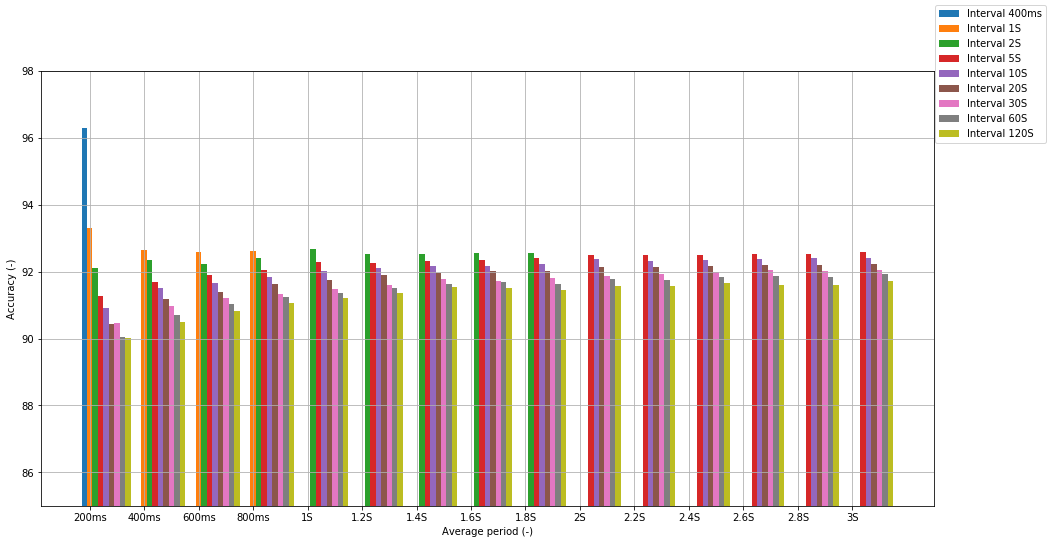

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
bar_width = 0.1
index = 0
for item in list_freqs_resample:
    ax.bar(np.arange(len(list_freqs_average)) + bar_width*index, accuracy_dict[item], bar_width, label = 'Interval ' + item)
    index += 1
    
ax.set_xticks(np.arange(len(list_freqs_average))+bar_width)
ax.set_xticklabels(list_freqs_average)
ax.set_ylim([85, 98])
ax.set_ylabel('Accuracy (-)')
ax.set_xlabel('Average period (-)')
fig.legend(loc='best')
ax.grid(True)
# display(test.head(10))
# display(noise_series.head(10))

## Conclusions
As seen in the graph above, averaging throughout more than 2-2.2S in any measurement interval does not provide any further interesting information. 

For a **reasonable publish interval period**, say, above **20S**, the an optimal averaging time would be between 1.4S and 2.2S, being the fist achieving a target of 92% accuracy. For higher intervals, a longer averaging up until 2.2S shows improvement.

For a **fast measurement interval**, 1S interval with a single shot measurement achieves the best accuracy, and also at 2S interval with 1S averaging.

**However** given the complexity of this implementation in firmware, and given that the gain for implementing this is <2% accuracy, it is not recommended to apply this.